In [1]:
!pip install mnist

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!tar -xf "/content/drive/My Drive/imimic/wann/cnn_weights.tar.xz" weights-72-0.9744-0.9918.hdf5

In [0]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import mnist
random.seed(1)
np.random.seed(1)

In [5]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

x_train = mnist.train_images()
y_train = mnist.train_labels()
x_test = mnist.test_images()
y_test = mnist.test_labels()

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.load_weights('weights-72-0.9744-0.9918.hdf5')



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
import os
import numpy as np
from skimage.transform import resize

MASK_PATH = os.path.join('rise_masks.npy')
MASK_COUNT = 5000
s = 8
p1 = 0.5

def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks


def explain(model, inp, masks, input_size):
    batch_size = 100
    preds = []
    # Make sure multiplication is being done for correct axes

    for i in range(0, MASK_COUNT, batch_size):
        sub_masks = masks[i:min(i + batch_size, MASK_COUNT)]
        masked = inp * sub_masks
        preds.append(model.predict(masked))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(MASK_COUNT, -1)).reshape(-1, *input_size)
    sal = sal / MASK_COUNT / p1
    return sal

masks = generate_masks(MASK_COUNT, s, p1, (28, 28))

label: 6
prediction label changed at 79 removed pixels


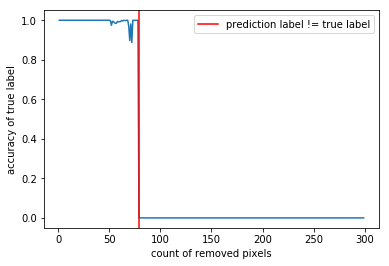

label: 9
prediction label changed at 30 removed pixels


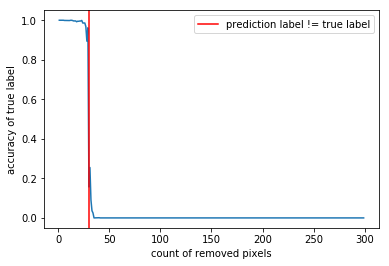

label: 2
prediction label changed at 70 removed pixels


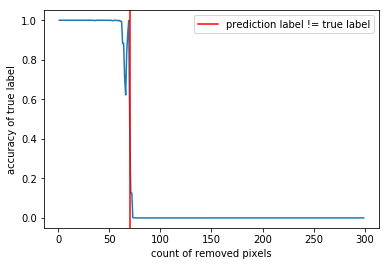

label: 6
prediction label changed at 75 removed pixels


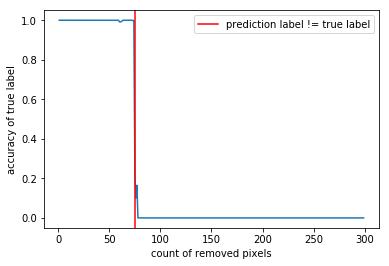

label: 7
prediction label changed at 84 removed pixels


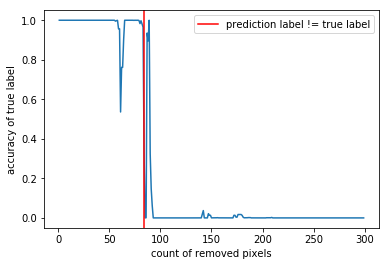

label: 6
prediction label changed at 51 removed pixels


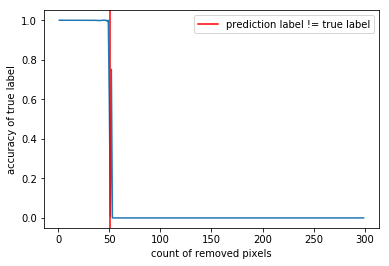

label: 1


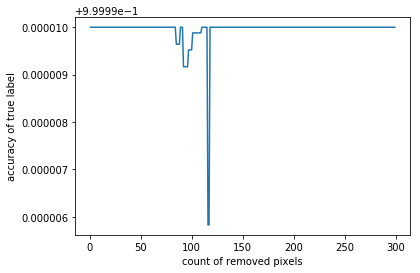

label: 4
prediction label changed at 59 removed pixels


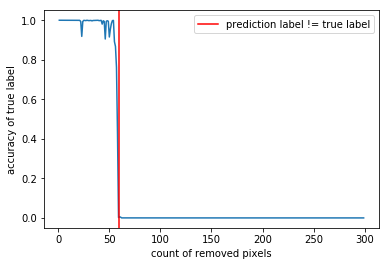

label: 7
prediction label changed at 177 removed pixels


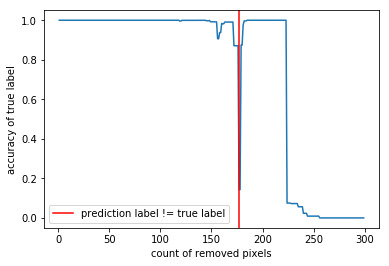

label: 1


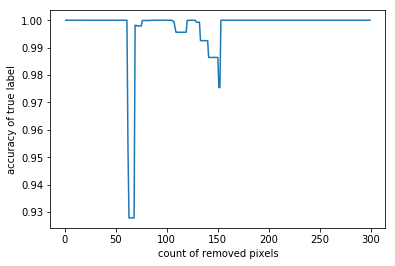

label: 1


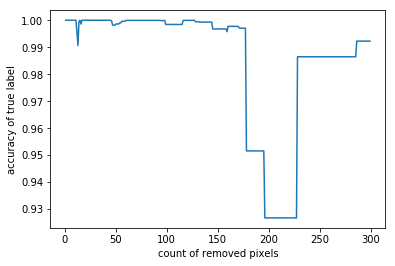

label: 1


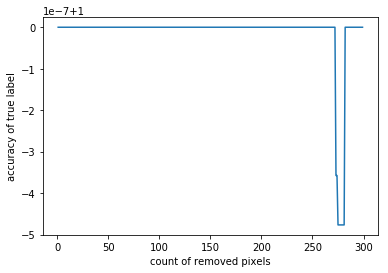

label: 3
prediction label changed at 44 removed pixels


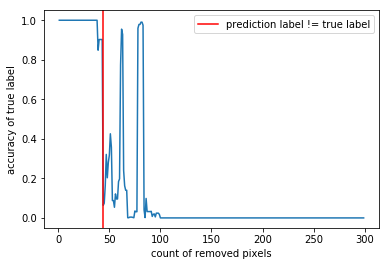

label: 9
prediction label changed at 10 removed pixels


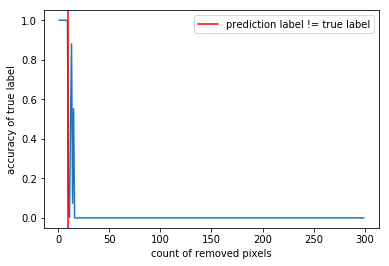

label: 0
prediction label changed at 11 removed pixels


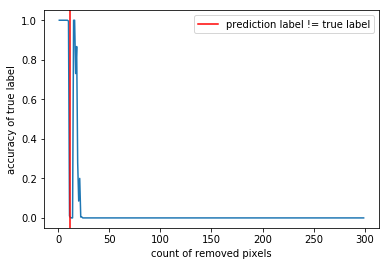

label: 2
prediction label changed at 30 removed pixels


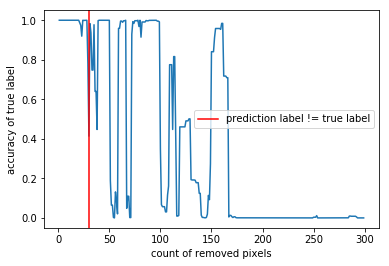

label: 7
prediction label changed at 16 removed pixels


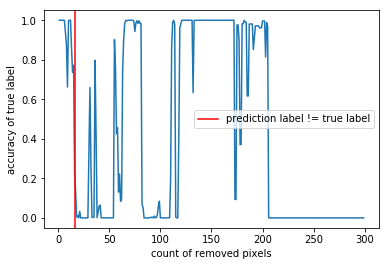

label: 2
prediction label changed at 93 removed pixels


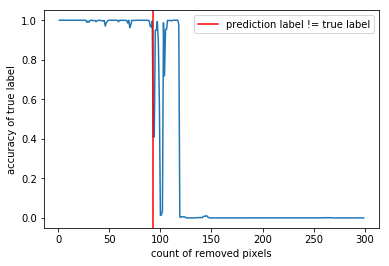

label: 4
prediction label changed at 13 removed pixels


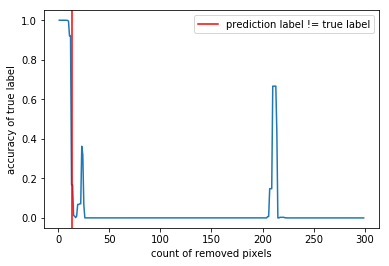

label: 6
prediction label changed at 53 removed pixels


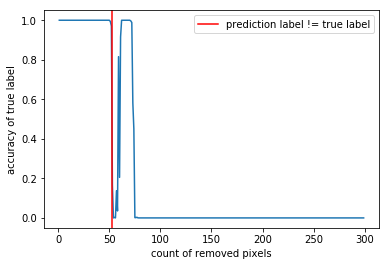

In [8]:
def evaluate(index):
    image = x_test[index]

    label = np.argmax(y_test[index])
    print('label:', label)

    baseline = model.predict(image.reshape(1, 28, 28, 1))
    predicted_label = np.argmax(baseline[0])

    sal = explain(model, image, masks, (28, 28))

    if predicted_label != label:
      print('Network did not recognize unchanged image, skipping')
      return

    flat = sal[label].reshape(28*28)
    
    prediction_label_change = None
    accuracies = []

    for count in range(1, 300):
        highest_indexes = np.argpartition(flat, -count)[-count:]

        modified_img = np.copy(image.reshape(28 * 28))
        modified_img[highest_indexes] = 0
        new_prediction = model.predict(modified_img.reshape(1, 28, 28, 1))
        accuracies.append(new_prediction[0][label])
        new_prediction_label = np.argmax(new_prediction[0])
        
        if new_prediction_label != label and not prediction_label_change:
            prediction_label_change = count

    x = list(range(1, 300))

    plt.plot(x, accuracies)
    #plt.axis([min(x), max(x), 0.0, 1.0,])
    plt.ylabel('accuracy of true label')
    plt.xlabel('count of removed pixels')
    if prediction_label_change:
        print(f'prediction label changed at {prediction_label_change} removed pixels')
        plt.axvline(prediction_label_change, label='prediction label != true label', c='red')
        plt.legend()

    plt.show()
    
    from IPython.display import HTML, display
    display(HTML('<hr>'))

  
for index in [9953, 3850, 4962, 3886, 5437, 8517, 2041, 1989, 1933, 9984, 8418, 
              2418, 6811, 1217, 6978, 6111, 7865, 7781, 7775, 7039]:
    evaluate(index)